In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
reviews = pd.read_csv('amazon_baby.csv')

In [4]:
reviews.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


## Data Preprocessing and exploration

In [5]:
# Dropping reviews with a rating of 3

reviews = reviews[reviews['rating'] != 3]

In [6]:
reviews.head()

,name,review,rating
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5


In [7]:
# Dropping the null data points
print(f'length of dataset before dropping nulls = {len(reviews)}')
reviews = reviews.dropna()
print(f'length of dataset after dropping nulls = {len(reviews)}')

length of dataset before dropping nulls = 166752
length of dataset after dropping nulls = 165679


In [8]:
# Adding the sentiments column, 1 for positive sentiment and 0 for negative sentiment
reviews['sentiment'] = reviews['rating'].apply(lambda x: 1 if x > 3 else 0)

Total Positive sentiments = 139318
Total Negative sentiments = 26361


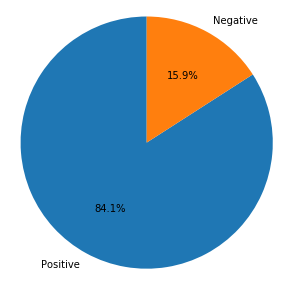

In [9]:
# visualizing the positive and negative sentiments
positive_reviews = reviews[reviews['sentiment'] == 1]
negative_reviews = reviews[reviews['sentiment'] == 0]
print(f'Total Positive sentiments = {len(positive_reviews)}')
print(f'Total Negative sentiments = {len(negative_reviews)}')      
fig = plt.figure(figsize=(5, 5))
labels = ['Positive', 'Negative']
sizes = [len(positive_reviews), len(negative_reviews)] 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

#### Performing Review Clean up Steps :
- 1. Removing stop words 
- 2. Removing Punctuations (punctuations which are adding meaning like emoticons :) :( are not removed)
- 3. Lowercase Reviews
- 4. Perfom Stemming

In [10]:
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def process_review(review):
    review_list = review.split()
    review_clean = []
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    for word in review_list:
        if word not in stopwords_english and word not in string.punctuation:
            word = word.translate(str.maketrans('','','@.,\'!!!'))
            if word != '':
                if re.search(r'[(]\w', word) is not None:
                    clean_word = word[1:].lower()
                    stem_word = stemmer.stem(clean_word)
                    review_clean.append(stem_word)
                elif re.search(r'\w[)]', word) is not None:
                    clean_word = word[:-1].lower()
                    stem_word = stemmer.stem(clean_word)
                    review_clean.append(stem_word)
                else:
                    clean_word = word.lower()
                    stem_word = stemmer.stem(clean_word)
                    review_clean.append(stem_word)
    cleaned_review = ' '.join(review_clean)
    return cleaned_review

In [11]:
# Test cases to check function
print(process_review('@Ankit is happy !!!, because ANKIT loves programming.! :)'))  # test case-1
print()
print(process_review('Hey! you, I am talking to you only !.'))  # test case-2
print()
print(process_review(reviews['review'][10])) # test case-3

ankit happi ankit love program :)

hey you i talk

i love journal nanni use everyday track daughter sleep eat activ the layout design make easi fill quickli comment column add detail ie ask nanni specifi food lunch amount milk took specif play time--tummi time walk park etc i love know detail babi day i also use track weekli overal schedul pattern chang ie babi nap time move natur get older)m complaint real space commun back nanni i sometim want repli nanni comment and/or leav note previou night ie babi sleep well babi rash etc instruct pleas use sun screen babi hot today i often forget tell rush morn i stick post-it note all all i highli recommend babi tracker


In [12]:
# Created a new column review clean to get the processed reviews
reviews['review_clean'] = reviews['review'].apply(process_review)

In [13]:
reviews.head()

,name,review,rating,sentiment,review_clean
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,1,came earli disappoint love planet wise bag wip...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,1,veri soft comfort warmer looksfit full size be...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,1,thi product well worth purchas i found anyth e...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,all kid cri non-stop i tri ween pacifi i found...
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,1,when binki fairi came hous special gift book h...


##### Tf-Idf vector of reviews clean

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
reviews_matrix = vectorizer.fit_transform(reviews['review_clean'])

In [36]:
reviews_matrix

<165679x96349 sparse matrix of type '<class 'numpy.float64'>'
	with 5897688 stored elements in Compressed Sparse Row format>

#### Original Imbalanced Data

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

model1 = LogisticRegression()

def lr_cv(X, y, n_splits, pipeline):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X,y):
        lr_fit = pipeline.fit(X[train], y[train])
        predictions = lr_fit.predict(X[test])
        accuracy.append(accuracy_score(y[test], predictions))
        recall.append(recall_score(y[test], predictions))
        precision.append(precision_score(y[test], predictions))
        f1.append(f1_score(y[test], predictions))
        print(f'Accuracy : {accuracy_score(y[test], predictions)}')
        print(f'Precision Score: {precision_score(y[test], predictions)}')
        print(f'Recall Score: {recall_score(y[test], predictions)}')
        print(f'F1 Score: {f1_score(y[test], predictions)}')
        print('|------------------------------------------------------|')
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    return lr_fit

In [54]:
from sklearn.pipeline import Pipeline

original_pipeline = Pipeline([('classifier', model1)])

lr = lr_cv(reviews_matrix, reviews['sentiment'].to_numpy(), 10, original_pipeline)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy : 0.9253425070915565
Precision Score: 0.93694499896744
Recall Score: 0.976959517657192
F1 Score: 0.9565339611370745
|------------------------------------------------------|
Accuracy : 0.9218372766779334
Precision Score: 0.9326258130777131
Recall Score: 0.9776772896927935
F1 Score: 0.9546203174825665
|------------------------------------------------------|
Accuracy : 0.9250362143891839
Precision Score: 0.9365625430026145
Recall Score: 0.9770312948607522
F1 Score: 0.9563690016159629
|------------------------------------------------------|
Accuracy : 0.9247947851279575
Precision Score: 0.9368457300275482
Recall Score: 0.9763853000287109
F1 Score: 0.9562069450302263
|------------------------------------------------------|
Accuracy : 0.9269676484789957
Precision Score: 0.938810706401766
Recall Score: 0.9768159632500718
F1 Score: 0.9574363303785002
|------------------------------------------------------|
Accuracy : 0.9281144374698214
Precision Score: 0.9390117841637379
Recall Score:

In [75]:
from sklearn.naive_bayes import MultinomialNB

model2 = MultinomialNB()

original_pipeline = Pipeline([('classifier', model2)])

lr2 = lr_cv(reviews_matrix, reviews['sentiment'].to_numpy(), 10, original_pipeline)

Accuracy : 0.8439254028607641
Precision Score: 0.8440266828380837
Recall Score: 0.9989951191501579
F1 Score: 0.9149957267766748
|------------------------------------------------------|
Accuracy : 0.8432520521487205
Precision Score: 0.8432144371101556
Recall Score: 0.9994257823715188
F1 Score: 0.9146986368861882
|------------------------------------------------------|
Accuracy : 0.8434331240946402
Precision Score: 0.8437007396629077
Recall Score: 0.9988515647430376
F1 Score: 0.9147439689739039
|------------------------------------------------------|
Accuracy : 0.8433124094640271
Precision Score: 0.8435567947630016
Recall Score: 0.9989233419465977
F1 Score: 0.9146894511994742
|------------------------------------------------------|
Accuracy : 0.8438556253017866
Precision Score: 0.8437670444215503
Recall Score: 0.9993540051679587
F1 Score: 0.9149935924818454
|------------------------------------------------------|
Accuracy : 0.8436745533558667
Precision Score: 0.8436969696969697
Recall Sc

In [103]:
lr.predict(vectorizer.transform(['This earphone']))

array([0], dtype=int64)